In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tifffile
from tqdm import tqdm
import glob
from pathlib import Path

In [4]:
image = tifffile.imread(".\\masks\\MPD 002-1.tif")
# image = image.transpose(2,1,0)
image.shape

(3, 104, 106)

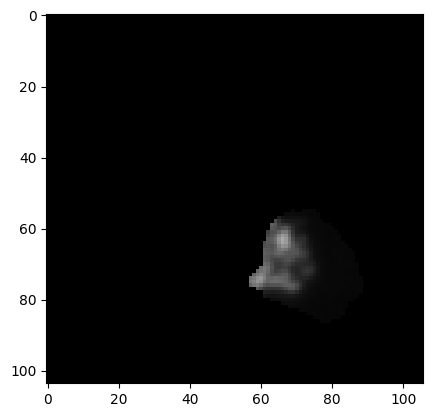

In [8]:
image_c2 = np.uint8(np.where(image[0]>0,1,0))                                     #mask
image_c2_3= cv2.cvtColor(image_c2 ,cv2.COLOR_GRAY2RGB)                
image_c1_3= cv2.cvtColor(image[1] ,cv2.COLOR_GRAY2RGB)                 
image_c0 = image[1]*image_c2                                                               
image_c0_3 = cv2.cvtColor(image_c0 ,cv2.COLOR_GRAY2RGB)
plt.imshow(image_c0_3)

In [9]:
def center_of_mass(image):
    total = image.sum()
    x_coord = (image.sum(axis=1) @ range(image.shape[0]))/total
    y_coord = (image.sum(axis=0) @ range(image.shape[1]))/total
    return x_coord,y_coord

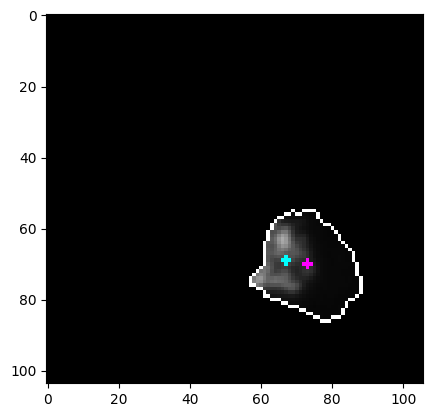

In [10]:
temp = np.uint8(cv2.cvtColor(image_c0,cv2.COLOR_GRAY2BGR))
contours, hierarchy = cv2.findContours(np.uint8(image[0]), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
area_list = []
data = pd.DataFrame(columns=["filename","id","centroid","center of mass","distance","area"])
for i in range(len(contours)):
    mm = cv2.moments(contours[i])
    if mm['m00'] != 0:
        # calculate mass center of cell
        cx = mm['m10']/mm['m00']
        cy = mm['m01']/mm['m00']
        # calculate centroid of cell fluorescence
        copy = np.zeros_like(temp)
        copy = cv2.drawContours(copy,[contours[i]],-1,(1,1,1),-1)
        mask = copy*temp
        cm = center_of_mass(cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY))
        mask = cv2.circle(mask, (int(cm[1]),int(cm[0])), 1, (0, 255, 255), -1)
        cv2.circle(mask, (int(cx), int(cy)), 1, (255,0, 255), -1)
        cv2.drawContours(mask,[contours[i]],-1,(255,255,255),1)
        area_list.append(mask)
        distance = np.sqrt(np.power((cx-cm[1]),2)+np.power((cy-cm[0]),2))
        area = np.sum(cv2.cvtColor(image_c2_3*copy,cv2.COLOR_BGR2GRAY)>0)
        data.loc[len(data.index)] = ("",i,[cx,cy],[cm[0],cm[1]],distance,area)
plt.imshow(np.uint8(sum(area_list)))

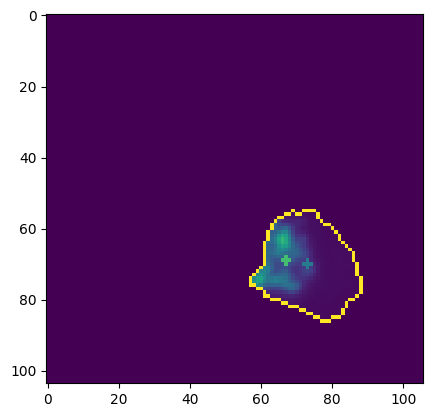

In [11]:
plt.imshow(np.uint8(cv2.cvtColor(sum(area_list),cv2.COLOR_RGB2GRAY)))

# Batch process

## For two fluorescence

In [21]:
# def center_of_mass(image):
#     # Calculate the center of mass of a binary or grayscale image.
#     total = image.sum()  # Compute the sum of all pixel intensities.
#     x_coord = (image.sum(axis=1) @ range(image.shape[0])) / total  # Calculate x-coordinate of the center of mass.
#     y_coord = (image.sum(axis=0) @ range(image.shape[1])) / total  # Calculate y-coordinate of the center of mass.
#     return x_coord, y_coord

# def pol_process(filename, image, dataframe):
#     # Process multi-channel image to extract fluorescence signals and calculate metrics.

#     # Prepare binary mask for channel 2 and convert it to a 3-channel image for visualization.
#     image_c2 = np.uint8(np.where(image[0] > 0, 1, 0))  # Binary mask for channel 2 (e.g., cell boundary).
#     image_c2_3 = cv2.cvtColor(image_c2, cv2.COLOR_GRAY2RGB)  # Convert channel 2 mask to 3-channel RGB.

#     # Mask and extract green fluorescence from channel 0 using channel 2 mask.
#     image_c0 = image[2] * image_c2
#     image_c0_3 = cv2.cvtColor(image_c0, cv2.COLOR_GRAY2RGB)  # Convert channel 0 to 3-channel RGB.

#     # Mask and extract red fluorescence from channel 1 using channel 2 mask.
#     image_c1 = image[3] * image_c2
#     image_c1_3 = cv2.cvtColor(image_c1, cv2.COLOR_GRAY2RGB)  # Convert channel 1 to 3-channel RGB.

#     # Calculate contours and extract features using the binary mask (channel 2).
#     temp_green = image_c0_3  # Green fluorescence for contour processing.
#     temp_red = image_c1_3  # Red fluorescence for contour processing.

#     # Find external contours from the channel 2 mask.
#     contours, hierarchy = cv2.findContours(image_c2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     # Initialize lists to store processed images.
#     area_list_red = []
#     area_list_green = []

#     for i in range(len(contours)):
#         # Calculate the centroid of the cell (geometric center).
#         mm = cv2.moments(contours[i])
#         if len(contours[i]) >= 5:  # Proceed only if the contour has enough points.
#             cx = mm['m10'] / mm['m00']  # x-coordinate of the centroid.
#             cy = mm['m01'] / mm['m00']  # y-coordinate of the centroid.

#             # Create a filled contour mask for the current cell.
#             copy = np.zeros_like(image_c2_3)  # Blank image for contour.
#             copy = cv2.drawContours(copy, [contours[i]], -1, (1, 1, 1), -1)  # Draw filled contour.

#             # Mask green and red fluorescence for the current cell.
#             mask_red = copy * temp_red
#             mask_green = copy * temp_green

#             # Calculate the center of mass for red and green fluorescence.
#             cm_red = center_of_mass(cv2.cvtColor(mask_red, cv2.COLOR_BGR2GRAY))
#             cm_green = center_of_mass(cv2.cvtColor(mask_green, cv2.COLOR_BGR2GRAY))

#             # Visualize the centers of mass and geometric centroids.
#             mask_red = cv2.circle(mask_red, (int(cm_red[1]), int(cm_red[0])), 3, (255, 255, 255), -1)  # Draw red center of mass.
#             mask_green = cv2.circle(mask_green, (int(cm_green[1]), int(cm_green[0])), 3, (255, 255, 255), -1)  # Draw green center of mass.

#             cv2.circle(mask_red, (int(cx), int(cy)), 2, (255, 255, 0), -1)  # Draw centroid on red mask.
#             cv2.circle(mask_green, (int(cx), int(cy)), 2, (255, 255, 0), -1)  # Draw centroid on green mask.

#             # Draw the cell contour on the masks.
#             cv2.drawContours(mask_red, [contours[i]], -1, (255, 255, 255), 1)
#             cv2.drawContours(mask_green, [contours[i]], -1, (255, 255, 255), 1)

#             # Add the processed images to the respective lists.
#             area_list_red.append(mask_red)
#             area_list_green.append(mask_green)

#             # Calculate the Euclidean distance between the center of mass and the centroid.
#             distance_red = np.sqrt(np.power((cx - cm_red[1]), 2) + np.power((cy - cm_red[0]), 2))
#             distance_green = np.sqrt(np.power((cx - cm_green[1]), 2) + np.power((cy - cm_green[0]), 2))

#             # Calculate the area of the cell using the mask.
#             area = np.sum(cv2.cvtColor(image_c2_3 * copy, cv2.COLOR_BGR2GRAY) > 0)

#             # Append the calculated metrics to the dataframe.
#             dataframe.loc[len(dataframe.index)] = (
#                 filename, i, area, cx, cy, cm_red[1], cm_red[0], distance_red, cm_green[1], cm_green[0], distance_green
#             )

#     return dataframe, area_list_green, area_list_red


In [24]:
# dataframe = pd.DataFrame(columns=["filename","id","area","cx","cy","cm_red[1]","cm_red[0]","distance_red","cm_green[1]","cm_green[0]","distance_green"])

# # Get a list of all .tif files in the ./masks/ directory.
# filepath_list = glob.glob("./masks/*.tif")

# # Define a new directory to store processed results.
# new_dir = "./process/"

# # Extract filenames and parent directory names from the file paths.
# filename_list = [str(Path(i).parts[-1]) for i in filepath_list]
# filedir_list = [str(Path(i).parts[-2]) for i in filepath_list]

# # Loop through each file in the list, displaying a progress bar with tqdm.
# for i in tqdm(range(len(filename_list))):
#     # Read the multi-channel image file.
#     image = tifffile.imread(filepath_list[i])

#     # Process the image and update the dataframe with the results.
#     dataframe, area_list_green, area_list_red = pol_process(filename_list[i], image, dataframe)

#     # If green area list is not empty, process and save the output.
#     if len(area_list_green) != 0:
#         # Combine the green and red masks into single-channel images.
#         new_green = cv2.cvtColor(sum(area_list_green), cv2.COLOR_RGB2GRAY)
#         new_red = cv2.cvtColor(sum(area_list_red), cv2.COLOR_RGB2GRAY)

#         # Write the processed images and original channels to the output directory.
#         tifffile.imwrite("{}".format(new_dir + filename_list[i]), np.uint8(new_green), append=True)
#         tifffile.imwrite("{}".format(new_dir + filename_list[i]), np.uint8(image[2]), append=True)  # Original green channel.
#         tifffile.imwrite("{}".format(new_dir + filename_list[i]), np.uint8(new_red), append=True)
#         tifffile.imwrite("{}".format(new_dir + filename_list[i]), np.uint8(image[3]), append=True)  # Original red channel.
#         tifffile.imwrite("{}".format(new_dir + filename_list[i]), np.uint8(image[0]), append=True)  # Binary mask channel.
#         tifffile.imwrite("{}".format(new_dir + filename_list[i]), np.uint8(image[1]), append=True)  # Other channel.

# # Save the dataframe containing all processed information as a CSV file.
# dataframe.to_csv(new_dir + "data.csv")


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 27.90it/s]


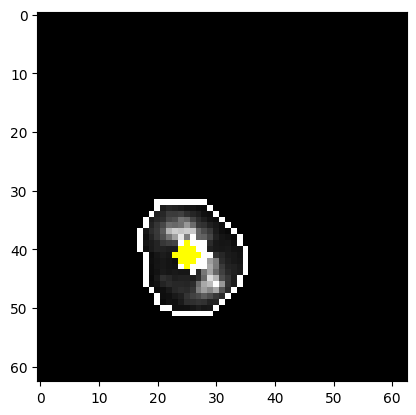

In [23]:
plt.imshow(sum(area_list_green))

## For single fluorescence

In [12]:
def center_of_mass(image):
    # Calculate the center of mass of a binary or grayscale image.
    total = image.sum()  # Compute the sum of all pixel intensities.
    x_coord = (image.sum(axis=1) @ range(image.shape[0])) / total  # Calculate x-coordinate of the center of mass.
    y_coord = (image.sum(axis=0) @ range(image.shape[1])) / total  # Calculate y-coordinate of the center of mass.
    return x_coord, y_coord

def pol_process(filename, image, dataframe):
    # Process the multi-channel image to extract fluorescence signals and calculate metrics.

    # Prepare binary mask for channel 0 and convert it to a 3-channel image for visualization.
    image_c2 = np.uint8(np.where(image[0] > 0, 1, 0))  # Binary mask for channel 0 (e.g., cell boundary).
    image_c2_3 = cv2.cvtColor(image_c2, cv2.COLOR_GRAY2RGB)  # Convert channel 0 mask to 3-channel RGB.

    # Mask and extract green fluorescence from channel 1 using channel 0 mask.
    image_c0 = image[1] * image_c2
    image_c0_3 = cv2.cvtColor(image_c0, cv2.COLOR_GRAY2RGB)  # Convert channel 1 to 3-channel RGB.

    # Calculate contours and extract features using the binary mask (channel 0).
    temp_green = image_c0_3  # Green fluorescence for contour processing.

    # Find external contours from the channel 0 mask.
    contours, hierarchy = cv2.findContours(np.uint8(image[0]), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize list to store processed green area masks.
    area_list_green = []

    for i in range(len(contours)):
        # Calculate the centroid of the cell (geometric center).
        mm = cv2.moments(contours[i])
        if len(contours[i]) >= 5:  # Proceed only if the contour has enough points.
            cx = mm['m10'] / mm['m00']  # x-coordinate of the centroid.
            cy = mm['m01'] / mm['m00']  # y-coordinate of the centroid.

            # Create a filled contour mask for the current cell.
            copy = np.zeros_like(image_c2_3)  # Blank image for contour.
            copy = cv2.drawContours(copy, [contours[i]], -1, (1, 1, 1), -1)  # Draw filled contour.

            # Mask green fluorescence for the current cell.
            mask_green = copy * temp_green

            # Calculate the center of mass for green fluorescence.
            cm_green = center_of_mass(cv2.cvtColor(mask_green, cv2.COLOR_BGR2GRAY))

            # Visualize the centers of mass and geometric centroids.
            mask_green = cv2.circle(mask_green, (int(cm_green[1]), int(cm_green[0])), 3, (255, 255, 255), -1)  # Draw green center of mass.
            cv2.circle(mask_green, (int(cx), int(cy)), 2, (255, 255, 0), -1)  # Draw centroid on green mask.

            # Draw the cell contour on the green mask.
            cv2.drawContours(mask_green, [contours[i]], -1, (255, 255, 255), 1)

            # Add the processed image to the green area list.
            area_list_green.append(mask_green)

            # Calculate the Euclidean distance between the center of mass and the centroid.
            distance_green = np.sqrt(np.power((cx - cm_green[1]), 2) + np.power((cy - cm_green[0]), 2))

            # Calculate the area of the cell using the mask.
            area = np.sum(cv2.cvtColor(image_c2_3 * copy, cv2.COLOR_BGR2GRAY) > 0)

            # Append the calculated metrics to the dataframe.
            dataframe.loc[len(dataframe.index)] = (
                filename, i, area, cx, cy, cm_green[1], cm_green[0], distance_green
            )

    return dataframe, area_list_green


In [13]:
dataframe = pd.DataFrame(columns=["filename","id","area","cx","cy","cm_green[1]","cm_green[0]","distance_green"])

# Get a list of all .tif files in the ./masks/ directory.
filepath_list = glob.glob("./masks/*.tif")

# Define a new directory to store processed results.
new_dir = "./process/"

# Extract filenames from the file paths.
filename_list = [str(Path(i).parts[-1]) for i in filepath_list]

# Loop through each file in the list, displaying a progress bar with tqdm.
for i in tqdm(range(len(filename_list))):
    # Read the multi-channel image file.
    image = tifffile.imread(filepath_list[i])

    # Process the image and update the dataframe with the results.
    dataframe, area_list_green = pol_process(filename_list[i], image, dataframe)

    # If green area list is not empty, process and save the output.
    if len(area_list_green) != 0:
        # Combine the green masks into a single-channel image.
        new_green = cv2.cvtColor(sum(area_list_green), cv2.COLOR_RGB2GRAY)

        # Write the processed green image and original channels to the output directory.
        tifffile.imwrite("{}".format(new_dir + filename_list[i]), np.uint8(new_green), append=True)
        tifffile.imwrite("{}".format(new_dir + filename_list[i]), np.uint8(image[0]), append=True)  # Binary mask channel.
        tifffile.imwrite("{}".format(new_dir + filename_list[i]), np.uint8(image[1]), append=True)  # Green channel.
        tifffile.imwrite("{}".format(new_dir + filename_list[i]), np.uint8(image[2]), append=True)  # Other channel.

# Save the dataframe containing all processed information as a CSV file.
dataframe.to_csv(new_dir + "data.csv")

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.78it/s]


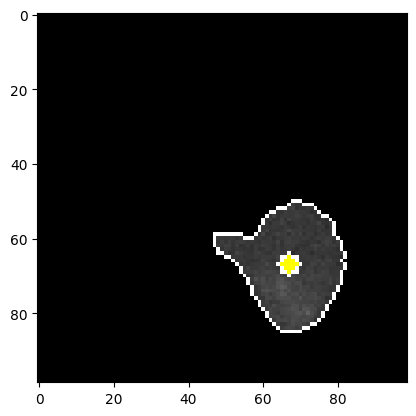

In [14]:
plt.imshow(sum(area_list_green))

In [14]:
filepath_list

['.\\2D 20230707-1800_xy1-1.tif',
 '.\\2D 20230707-1800_xy1-2.tif',
 '.\\2D 20230707-1800_xy1-3.tif',
 '.\\2D 20230707-1800_xy1-4.tif',
 '.\\2D 20230707-1800_xy1-5.tif',
 '.\\2D 20230707-1800_xy1-6.tif',
 '.\\2D 20230707-1800_xy1-7.tif',
 '.\\2D 20230707-1800_xy1-8.tif',
 '.\\2D 20230707-1800_xy10-1.tif',
 '.\\2D 20230707-1800_xy10-10.tif',
 '.\\2D 20230707-1800_xy10-11.tif',
 '.\\2D 20230707-1800_xy10-12.tif',
 '.\\2D 20230707-1800_xy10-13.tif',
 '.\\2D 20230707-1800_xy10-14.tif',
 '.\\2D 20230707-1800_xy10-15.tif',
 '.\\2D 20230707-1800_xy10-16.tif',
 '.\\2D 20230707-1800_xy10-18.tif',
 '.\\2D 20230707-1800_xy10-19.tif',
 '.\\2D 20230707-1800_xy10-2.tif',
 '.\\2D 20230707-1800_xy10-20.tif',
 '.\\2D 20230707-1800_xy10-21.tif',
 '.\\2D 20230707-1800_xy10-22.tif',
 '.\\2D 20230707-1800_xy10-23.tif',
 '.\\2D 20230707-1800_xy10-3.tif',
 '.\\2D 20230707-1800_xy10-4.tif',
 '.\\2D 20230707-1800_xy10-5.tif',
 '.\\2D 20230707-1800_xy10-6.tif',
 '.\\2D 20230707-1800_xy10-7.tif',
 '.\\2D 2023070